In [2]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import nltk 
import matplotlib.pyplot as plt
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dados = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [4]:
dados.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


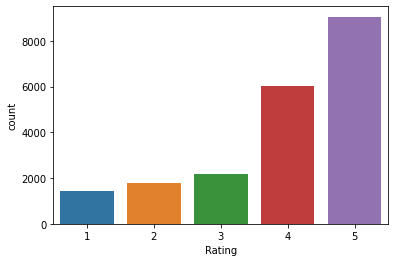

In [5]:
sns.countplot(dados['Rating']);

In [6]:
# Remove stopwords
# Remove punctuation 
# Remove extra whitespaces

sw = nltk.corpus.stopwords.words()

def clean_text(row):
  line = row['Review']
  words = line.split()
  line = " ".join(word for word in words if word not in sw and word.isalpha())
  row['Clean_text'] = line
  return row

In [7]:
dados = dados.apply(clean_text, axis = 1)

In [8]:
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [9]:
# downsample_2 = resample(dados[dados['Rating'] == 2], n_samples = len(dados[dados['Rating'] == 1]) , random_state = 301)
# downsample_3 = resample(dados[dados['Rating'] == 3], n_samples = len(dados[dados['Rating'] == 1]) , random_state = 301)
# downsample_4 = resample(dados[dados['Rating'] == 4], n_samples = len(dados[dados['Rating'] == 1]) , random_state = 301)
# downsample_5 = resample(dados[dados['Rating'] == 5], n_samples = len(dados[dados['Rating'] == 1]) , random_state = 301)

In [45]:
#df_final = pd.concat([dados[dados['Rating'] == 1], downsample_2, downsample_3, downsample_4, downsample_5])
df_final = dados

In [46]:
from keras.models import Sequential
import keras.layers as L
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [47]:
review = df_final['Clean_text'].copy()

In [48]:
token = Tokenizer()

In [49]:
token.fit_on_texts(review)

In [50]:
texts = token.texts_to_sequences(review)

In [51]:
texts = pad_sequences(texts, padding='post')

In [63]:
def encodeLabel(label):
    if label == 5 or label == 4: #If the rating is generally positive
        return 2 #Give the rating a 2 for positive
    if label == 3: #If the rating is generally neutral
        return 1 #Give the rating a 1 for neutral
    return 0 #Give the rating a 0 for negative

labels = ["Negative", "Neutral", "Positive"] #Give our labels a name
df_final["EncodedRating"] = df_final["Rating"].apply(encodeLabel)

In [65]:
x_treino, x_teste, y_treino, y_teste = train_test_split(texts, df_final['EncodedRating'], random_state = 301, stratify = df_final['Rating'])

In [66]:
size = len(token.word_index) + 1
epoch = 2
batchSize = 32
outputDim = 16
units = 256

In [73]:
model = Sequential()
model.add(L.Embedding(size, outputDim, input_length= texts.shape[1]))
model.add(L.Bidirectional(L.LSTM(units, return_sequences = True)))
model.add(L.GlobalMaxPool1D())
model.add(L.Dropout(0.3))
model.add(L.Dense(64, activation = 'relu'))
model.add(L.Dropout(0.3))
model.add(L.Dense(3))
model.compile(loss = SparseCategoricalCrossentropy(from_logits = True), optimizer = 'adam',metrics = ['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1481, 16)          706336    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 1481, 512)         559104    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)               

In [74]:
history = model.fit(x_treino, y_treino, epochs = 1, validation_split = 0.2, batch_size = batchSize) #Fit the model to the data

385/385 [==============================] - 74s 193ms/step - loss: 0.5822 - accuracy: 0.7903 - val_loss: 0.4111 - val_accuracy: 0.8409


In [ ]:
# history_dict = history.history
# history_dict.keys()

In [ ]:
# import matplotlib.pyplot as plt

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# # "bo" is for "blue dot"
# plt.plot(epochs, loss, 'bo', label='Training loss')
# # b is for "solid blue line"
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()


In [82]:
predicts = model.predict_classes(x_teste)
#loss, accuracy = model.evaluate(x_teste, y_teste)

In [83]:
print(classification_report(predicts,y_teste, target_names = labels))

              precision    recall  f1-score   support

    Negative       0.86      0.65      0.74      1074
     Neutral       0.00      0.00      0.00         0
    Positive       0.96      0.90      0.93      4049

    accuracy                           0.85      5123
   macro avg       0.61      0.51      0.56      5123
weighted avg       0.94      0.85      0.89      5123



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
